# Entropía AI Candidate Test: Ricardo Daniel Alatorre Cantú

## Advising Company X

We are tasked with reviewing sales data corresponding to a firm we will refer to as Company X, and leveraging that sales data to assess the state of Company X's sales and make recommendations where possible. 

We have two different datasets on hand in the form of Microsoft Excel (.xslx) files. The file top200_SKUs.xlsx contains sales data on the 200 best-selling products for each of the 39 regions which Company X divides Mexico into. The file ventas2017_2022.xlsx, on the other hand, contains the monthly sales history from January 2017 to December 2022 for each of the 39 regions.

## Importing Some Python Libraries

Our first order of business will be to import the Python libraries we'll be using throughout. Although some libraries will not be used until we're much further along in our analysis, it's generally considered good practice to import all relevant libraries at the outset such that a notebook's given user can spot which packages might be missing on their own system as soon as they start running the notebook.

In [191]:
## Basic libraries for data manipulation and visualization

import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

## Libraries for Principal Components Analysis and Clustering

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns
from matplotlib import pyplot as plt

## Libraries for time-series analysis (SARIMA)


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller # ADFuller Hypothesis test
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


## Checking for Data Integrity

Let's take an initial look at our data. We want to understand its layout, its content, as well as any abnormalities that might require cleaning.

We'll begin with our information on top-selling SKUs.

### Top 200 SKUs Data

In [192]:
sku_df = pd.read_excel('./top200_SKUs.xlsx')

In [193]:
sku_df.head()

,ZONA,SKU_000001,SKU_000002,SKU_000003,SKU_000004,SKU_000005,SKU_000006,SKU_000007,SKU_000008,SKU_000009,...,SKU_000191,SKU_000192,SKU_000193,SKU_000194,SKU_000195,SKU_000196,SKU_000197,SKU_000198,SKU_000199,SKU_000200
0,1,1.212099e+06,1.662853e+06,3.136545e+06,2.770269e+06,6.715570e+06,4.784077e+05,4.270451e+06,3.739209e+06,3.297076e+06,...,1.759146e+06,1.293314e+06,2.408767e+06,4.599697e+05,2.309683e+06,6.976844e+06,5.182221e+06,2.359301e+06,9.600805e+05,0.000000e+00
1,2,1.388387e+06,9.183441e+05,1.633432e+06,5.957102e+05,8.753465e+06,4.127367e+04,2.404877e+06,3.800591e+06,1.280679e+06,...,5.314734e+05,0.000000e+00,2.649029e+05,1.079788e+05,1.094261e+06,1.872017e+06,9.739656e+05,6.326533e+05,8.880741e+05,8.536321e+05
2,3,1.779890e+06,2.064487e+06,1.685203e+06,3.159571e+05,5.675680e+06,8.623577e+05,3.014339e+05,7.002510e+06,9.061692e+05,...,3.467634e+05,0.000000e+00,1.820579e+06,8.881345e+05,7.096253e+05,1.108717e+06,9.609145e+05,4.072129e+05,9.968178e+05,1.131421e+06
3,4,3.101737e+06,3.063763e+06,2.791287e+06,1.047550e+05,2.734516e+06,1.642425e+06,1.644228e+06,5.621550e+06,1.458318e+06,...,1.240459e+05,0.000000e+00,5.410279e+05,2.645447e+06,4.531791e+05,1.507338e+06,3.666610e+05,4.298142e+05,1.644299e+06,4.875458e+05
4,5,1.391194e+06,2.512046e+06,6.199125e+05,2.852016e+05,1.617794e+07,3.359666e+04,1.219657e+06,5.578319e+06,1.170495e+06,...,1.823382e+05,1.365828e+06,8.560284e+04,2.627755e+05,8.986822e+05,1.809659e+06,1.259695e+05,2.712530e+05,2.428611e+06,7.647507e+05


In [194]:
sku_df.shape

(39, 201)

It looks like each row represents sales data corresponding to a distinct zone (designated by the column Zona), whereas each column represents sales data corresponding to a given SKU out of the 200 top-selling SKUs. What's not exactly clear is whether this data represents units sold or some unit of currency. Let's think of them as 'sales units' in lieu of more information on them.

Something I can't help but notice is that SKU numbers begin at SKU_000001 and end at SKU_000200. There's three leading 0's we don't need to read on each label. Also our column for Zone is in Spanish. Let's fix both of those things so that our data is marginally easier to read.

In [195]:
sku_df.columns = [col.replace('000', '').replace('ZONA', 'Zone') for col in sku_df.columns]

In [196]:
sku_df.head()

,Zone,SKU_001,SKU_002,SKU_003,SKU_004,SKU_005,SKU_006,SKU_007,SKU_008,SKU_009,...,SKU_191,SKU_192,SKU_193,SKU_194,SKU_195,SKU_196,SKU_197,SKU_198,SKU_199,SKU_200
0,1,1.212099e+06,1.662853e+06,3.136545e+06,2.770269e+06,6.715570e+06,4.784077e+05,4.270451e+06,3.739209e+06,3.297076e+06,...,1.759146e+06,1.293314e+06,2.408767e+06,4.599697e+05,2.309683e+06,6.976844e+06,5.182221e+06,2.359301e+06,9.600805e+05,0.000000e+00
1,2,1.388387e+06,9.183441e+05,1.633432e+06,5.957102e+05,8.753465e+06,4.127367e+04,2.404877e+06,3.800591e+06,1.280679e+06,...,5.314734e+05,0.000000e+00,2.649029e+05,1.079788e+05,1.094261e+06,1.872017e+06,9.739656e+05,6.326533e+05,8.880741e+05,8.536321e+05
2,3,1.779890e+06,2.064487e+06,1.685203e+06,3.159571e+05,5.675680e+06,8.623577e+05,3.014339e+05,7.002510e+06,9.061692e+05,...,3.467634e+05,0.000000e+00,1.820579e+06,8.881345e+05,7.096253e+05,1.108717e+06,9.609145e+05,4.072129e+05,9.968178e+05,1.131421e+06
3,4,3.101737e+06,3.063763e+06,2.791287e+06,1.047550e+05,2.734516e+06,1.642425e+06,1.644228e+06,5.621550e+06,1.458318e+06,...,1.240459e+05,0.000000e+00,5.410279e+05,2.645447e+06,4.531791e+05,1.507338e+06,3.666610e+05,4.298142e+05,1.644299e+06,4.875458e+05
4,5,1.391194e+06,2.512046e+06,6.199125e+05,2.852016e+05,1.617794e+07,3.359666e+04,1.219657e+06,5.578319e+06,1.170495e+06,...,1.823382e+05,1.365828e+06,8.560284e+04,2.627755e+05,8.986822e+05,1.809659e+06,1.259695e+05,2.712530e+05,2.428611e+06,7.647507e+05


Let's take a closer look at what's contained within this dataframe. Do we have any null values in here?

In [197]:
sku_df.isnull().sum()

Zone       0
SKU_001    0
SKU_002    0
SKU_003    0
SKU_004    0
          ..
SKU_196    0
SKU_197    0
SKU_198    0
SKU_199    0
SKU_200    0
Length: 201, dtype: int64

At first blush it looks like we don't have any null values in each of our columns, but the fact is that we have 201 columns, and we can't see all of them in this initial view. Let's double-check by means of a second aggregation.

In [198]:
sku_df.isnull().sum().sum()

0

Really looks like there's no null values here. However, let's perform some changes to the Zone column. Right now we seem to have Zone logged as a numeric value, when in reality the number in question is simply a label rather than a quantitative measure. Let's turn the Zone column into a string so this is more clear, and let's make sure that our labels are all in English.

In [199]:
sku_col = [col for col in sku_df.columns if col != 'Zone']
sku_df['Zone'] = 'Zone ' + sku_df['Zone'].astype(str)

In [200]:
sku_df.head()

,Zone,SKU_001,SKU_002,SKU_003,SKU_004,SKU_005,SKU_006,SKU_007,SKU_008,SKU_009,...,SKU_191,SKU_192,SKU_193,SKU_194,SKU_195,SKU_196,SKU_197,SKU_198,SKU_199,SKU_200
0,Zone 1,1.212099e+06,1.662853e+06,3.136545e+06,2.770269e+06,6.715570e+06,4.784077e+05,4.270451e+06,3.739209e+06,3.297076e+06,...,1.759146e+06,1.293314e+06,2.408767e+06,4.599697e+05,2.309683e+06,6.976844e+06,5.182221e+06,2.359301e+06,9.600805e+05,0.000000e+00
1,Zone 2,1.388387e+06,9.183441e+05,1.633432e+06,5.957102e+05,8.753465e+06,4.127367e+04,2.404877e+06,3.800591e+06,1.280679e+06,...,5.314734e+05,0.000000e+00,2.649029e+05,1.079788e+05,1.094261e+06,1.872017e+06,9.739656e+05,6.326533e+05,8.880741e+05,8.536321e+05
2,Zone 3,1.779890e+06,2.064487e+06,1.685203e+06,3.159571e+05,5.675680e+06,8.623577e+05,3.014339e+05,7.002510e+06,9.061692e+05,...,3.467634e+05,0.000000e+00,1.820579e+06,8.881345e+05,7.096253e+05,1.108717e+06,9.609145e+05,4.072129e+05,9.968178e+05,1.131421e+06
3,Zone 4,3.101737e+06,3.063763e+06,2.791287e+06,1.047550e+05,2.734516e+06,1.642425e+06,1.644228e+06,5.621550e+06,1.458318e+06,...,1.240459e+05,0.000000e+00,5.410279e+05,2.645447e+06,4.531791e+05,1.507338e+06,3.666610e+05,4.298142e+05,1.644299e+06,4.875458e+05
4,Zone 5,1.391194e+06,2.512046e+06,6.199125e+05,2.852016e+05,1.617794e+07,3.359666e+04,1.219657e+06,5.578319e+06,1.170495e+06,...,1.823382e+05,1.365828e+06,8.560284e+04,2.627755e+05,8.986822e+05,1.809659e+06,1.259695e+05,2.712530e+05,2.428611e+06,7.647507e+05


### Monthly Sales History (2017-2022) Data

Similarly, we should take a look at the integrity of the Monthly Sales History Data.

In [201]:
zts_df = pd.read_excel('./ventas2017_2022.xlsx')

In [202]:
zts_df.head(5)

,ZONA,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,...,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12
0,1,9.873875e+06,9.540396e+06,1.122003e+07,9.876677e+06,1.149008e+07,1.091888e+07,9.356538e+06,1.049258e+07,9.780397e+06,...,1.644067e+07,1.486155e+07,1.692956e+07,1.614367e+07,1.759623e+07,1.772818e+07,1.706083e+07,1.736282e+07,2.316456e+07,6.402245e+06
1,2,5.228411e+06,5.547264e+06,6.591042e+06,6.239016e+06,6.401350e+06,6.155254e+06,5.681139e+06,6.159061e+06,6.492854e+06,...,1.048342e+07,7.769870e+06,8.088835e+06,8.132009e+06,8.938827e+06,9.674604e+06,8.961393e+06,9.047043e+06,1.022036e+07,3.280221e+06
2,3,7.268431e+06,6.507043e+06,8.361120e+06,6.560573e+06,7.608588e+06,6.898334e+06,6.659884e+06,7.455095e+06,6.560414e+06,...,1.144376e+07,1.018457e+07,1.125141e+07,1.119392e+07,1.044417e+07,9.281830e+06,1.065263e+07,1.160463e+07,1.005723e+07,5.334014e+06
3,4,7.066948e+06,6.687970e+06,8.133912e+06,6.676082e+06,8.175272e+06,7.376892e+06,6.992252e+06,7.745622e+06,7.919577e+06,...,1.233559e+07,1.017459e+07,1.072309e+07,1.207746e+07,1.186533e+07,1.145147e+07,1.146757e+07,1.020621e+07,1.098515e+07,5.163151e+06
4,5,5.303134e+06,5.133612e+06,5.955766e+06,5.617922e+06,5.670728e+06,5.583939e+06,5.752821e+06,5.651055e+06,6.047120e+06,...,8.084046e+06,6.845954e+06,7.123049e+06,8.097289e+06,7.751273e+06,7.292691e+06,7.368594e+06,8.109758e+06,7.908011e+06,3.484061e+06


We have monthly sales data corresponding to each zone. Our data runs from 2017 through 2022, for a total of 6 years' worth of information.

In [203]:
zts_df.shape

(39, 73)

We once again check for null values.

In [204]:
zts_df.isnull().sum().sum()

0

Looks like we don't have any null values. However, let's perform the same changes we made to the Zone column in the previous dataset, for consistency.

In [205]:
zts_df.columns = [col.replace('ZONA', 'Zone') for col in zts_df.columns]
zts_df['Zone'] = 'Zone ' + zts_df['Zone'].astype(str)

In [206]:
zts_df.head(5)

,Zone,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,...,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12
0,Zone 1,9.873875e+06,9.540396e+06,1.122003e+07,9.876677e+06,1.149008e+07,1.091888e+07,9.356538e+06,1.049258e+07,9.780397e+06,...,1.644067e+07,1.486155e+07,1.692956e+07,1.614367e+07,1.759623e+07,1.772818e+07,1.706083e+07,1.736282e+07,2.316456e+07,6.402245e+06
1,Zone 2,5.228411e+06,5.547264e+06,6.591042e+06,6.239016e+06,6.401350e+06,6.155254e+06,5.681139e+06,6.159061e+06,6.492854e+06,...,1.048342e+07,7.769870e+06,8.088835e+06,8.132009e+06,8.938827e+06,9.674604e+06,8.961393e+06,9.047043e+06,1.022036e+07,3.280221e+06
2,Zone 3,7.268431e+06,6.507043e+06,8.361120e+06,6.560573e+06,7.608588e+06,6.898334e+06,6.659884e+06,7.455095e+06,6.560414e+06,...,1.144376e+07,1.018457e+07,1.125141e+07,1.119392e+07,1.044417e+07,9.281830e+06,1.065263e+07,1.160463e+07,1.005723e+07,5.334014e+06
3,Zone 4,7.066948e+06,6.687970e+06,8.133912e+06,6.676082e+06,8.175272e+06,7.376892e+06,6.992252e+06,7.745622e+06,7.919577e+06,...,1.233559e+07,1.017459e+07,1.072309e+07,1.207746e+07,1.186533e+07,1.145147e+07,1.146757e+07,1.020621e+07,1.098515e+07,5.163151e+06
4,Zone 5,5.303134e+06,5.133612e+06,5.955766e+06,5.617922e+06,5.670728e+06,5.583939e+06,5.752821e+06,5.651055e+06,6.047120e+06,...,8.084046e+06,6.845954e+06,7.123049e+06,8.097289e+06,7.751273e+06,7.292691e+06,7.368594e+06,8.109758e+06,7.908011e+06,3.484061e+06


There's one more piece of this I'm curious about. We expect to work with both datasets. Do they 'agree' with each other? On one hand, one dataset contains sales data on the top 200 best-selling SKUs for each zone, whereas the other dataset contains monthly sales data for each zone across several years.

Does the total sales data by zone in the top_200_SKU file represent the same sales across 2017-2022 that we see in the other file? Let's run a quick aggregation and see if they align!

In [207]:
sum(sku_df.set_index('Zone').sum(axis=1) == zts_df.set_index('Zone').sum(axis=1))

0

Looks like there isn't a single case in which the sum of the sales of the top 200 SKUs in each zone match the total sales of each zone from 2017 through 2022. Let's take a quick look and try to suss out why:

In [208]:
comp_df = pd.DataFrame({'top_200_sales': sku_df.set_index('Zone').sum(axis=1),
                        '2017_2022_sales': zts_df.set_index('Zone').sum(axis=1)})
comp_df.head()

,top_200_sales,2017_2022_sales
Zone,,
Zone 1,6.527845e+08,9.891863e+08
Zone 2,3.098466e+08,5.903093e+08
Zone 3,4.025904e+08,6.369174e+08
Zone 4,4.989187e+08,7.228230e+08
Zone 5,2.686038e+08,4.703190e+08


In [209]:
sum(sku_df.set_index('Zone').sum(axis=1) <= zts_df.set_index('Zone').sum(axis=1))

39

It seems that 2017-2022 sales in each region tend to be higher than the sales for the top 200 SKUs in each region. One likely reason for this is that Company X likely sells more than 200 different SKUs in each region.

In [210]:
round(sum(sku_df.set_index('Zone').sum(axis=1))/sum(zts_df.set_index('Zone').sum(axis=1)), 2)

0.68

In fact, it seems that the total sales in the top_200_SKUs file represent only about 68% of the total sales logged in the 2017_2022 sales file. The data in the top_200_SKUs file thus most likely represents sales across multiple years (rather than a snapshot of a single year), but only represents a fraction of the total.

We will proceed from the *asssumption* that the sales in the top_200_SKU file also represent sales data corresponding to the period from 2017 through 2022, but only sales data corresponding to the top 200 best-selling SKUs overall.

## Exploratory Data Analysis (EDA)

Given we are working with 200 SKUs, 39 Zones, and 72 months across our two datasets, our Exploratory Data Analysis would benefit from the construction of a handful of visualizations, that we might get an intuitive understanding of our data's contours. 

First I will reshape our SKUs dataset such that we only have three columns: The Zone, the SKU in question, and the total Sales associated with each Zone-SKU combination. This will make our plotting more straightforward.

### Sales of the Top 200 SKUs by Zone

In [211]:
sku_melt = pd.melt(sku_df, id_vars = ['Zone'], var_name = 'SKU', value_name = 'Sales')

In [212]:
sku_melt.head()

,Zone,SKU,Sales
0,Zone 1,SKU_001,1.212099e+06
1,Zone 2,SKU_001,1.388387e+06
2,Zone 3,SKU_001,1.779890e+06
3,Zone 4,SKU_001,3.101737e+06
4,Zone 5,SKU_001,1.391194e+06


In [213]:
top_skus = sku_melt[['SKU', 'Sales']].groupby('SKU').sum().sort_values(by=['Sales'], ascending=False).reset_index()
fig = px.bar(top_skus, x='SKU', y='Sales', title='Top 200 SKUs by Sales')
fig.show()

Looks like the vast majoirty of SKUs make less than 0.2B in sales each, but the handful of those that do tend to sell a lot more. Let's see if we can narrow down our visualization here to get a closer look.

In [214]:
top_50_skus = sku_melt[['SKU', 'Sales']].groupby('SKU').sum().sort_values(by=['Sales'], ascending=False).reset_index().head(50)
fig = px.bar(top_50_skus, x='SKU', y='Sales', title='Top 50 SKUs by Sales')
fig.show()

It is truly only a handful of SKUs that break the 0.2B mark. Let's look at the top 10 instead.

In [215]:
top_10_skus = sku_melt[['SKU', 'Sales']].groupby('SKU').sum().sort_values(by=['Sales'], ascending=False).reset_index().head(10)
fig = px.bar(top_10_skus, x='SKU', y='Sales', title='Top 10 SKUs by Sales')
fig.show()

Clearly SKU_162 is our 'star performer'. The distance between it and it's closest competitor, SKU_047, is nearly the size of the sales of our sixth-best performing SKU, SKU_107.

### Top-Performing Zones

Now let's do something similar for Zones. Which zones tend to sell the most out of the set of top 200 SKUs?

In [216]:
top_zones = sku_melt[['Zone', 'Sales']].groupby('Zone').sum().sort_values(by=['Sales'], ascending=False).reset_index()
fig = px.bar(top_zones, x='Zone', y='Sales', title='Top Zones')
fig.show()

When it comes to Zones, it seems we also have a distribution where we have a handful of standouts. Zone 28, Zone 24 and Zone 14 dominate all other zones when it comes to total sales, the majority of which hover marginally above or below 0.5B in sales. My guess is that these top three zones correspond to Mexico's major metropolitan areas and markets such as Mexico City, Guadalajara, and Monterrey, albeit in lieu of more information this is just speculation.

Which Zones are successful and which Zones are not might come down to the mix of SKUs being sold in each. Let's disaggregate total sales by Zone by SKUs and see if we can find some patterns.

Let's take a look at what's sold in the top 5 zones, and perhaps contrast it with what's sold in the bottom 5 zones.

In [217]:
t_5 = sku_melt[['Zone', 'Sales']].groupby('Zone').sum().sort_values(by=['Sales'], ascending=False).reset_index().head(5)['Zone']
b_5 = sku_melt[['Zone', 'Sales']].groupby('Zone').sum().sort_values(by=['Sales'], ascending=True).reset_index().head(5)['Zone']

top_5 = sku_melt[sku_melt['Zone'].isin(t_5)]
bottom_5 = sku_melt[sku_melt['Zone'].isin(b_5)]

In [218]:
fig = px.bar(top_5, x='Zone', y='Sales', color='SKU', title='Distribution of SKUs by Zone - Top 5 Zones by Sales')
fig.show()

Here we see that in the top five Zones by Sales, we have a relatively even distribution of SKUs, with a few notable exceptions. In both of our top two zones, Zone 28 and Zone 24, we see a large block of sales is made up of SKU_162 (which we can appreciate in the large blocks of red), which is our highest-selling SKU overall. The only SKUs that are prominent enough to stand out at all elsewhere are SKU_047 (which sells evenly across Zones 14, 24, 28 and 30) and SKU_164 (most prominently in Zone 28), but contrasted against the size of the amount of SKU_162 that is sold in Zones 24 and 28, these seem marginal. One thing's for sure, however, our biggest two markets, Zone 24 and Zone 28, rely on sales of ZKU_162 to come out on top compared to other zones.

Now let's take a look at the distribution of SKUs in the bottom 5 Zones by Sales.

In [219]:
fig = px.bar(bottom_5, x='Zone', y='Sales', color='SKU', title='Distribution of SKUs by Zone - Bottom 5 Zones')
fig.show()

In the bottom five zones, we see a much more even distribution of SKUs than we did in the top five zones. With the occasional marginal exception (e.g., SKU_097 in Zone 22 and Zone 37), we generally do not see a 'star product' driving sales in each zone.

Let's expand our range just a little bit more. What is the SKU composition for the top 10 Zones by Sales?

In [220]:
t_10 = sku_melt[['Zone', 'Sales']].groupby('Zone').sum().sort_values(by=['Sales'], ascending=False).reset_index().head(10)['Zone']
top_10 = sku_melt[sku_melt['Zone'].isin(t_10)]
fig = px.bar(top_10, x='Zone', y='Sales', color='SKU', title='Distribution of SKUs by Zone - Top 10 Zones')
fig.show()

Here we see That Zone 24 and Zone 28's very high SKU_192 sales are somehting of an anomaly. On the other hand, across the top 10 Zones by Sales, we see blocks of SKU_047 show up more consistently.

### Top 200 SKUs Data - EDA Summary

So far, our Top 200 SKU Data is telling us the following:
   1) Out of 39 Zones, a handful stand above the rest in terms of sales: Zone 28, Zone 24, Zone 14 and Zone 11.
   2) Out of 200 SKUs, only a handful make about 0.5B in sales or more: SKU_162, SKU_047, SKU_097, SKU_022, and SKU 015, with SKU_162 towering above the rest at about 1.2B in sales.
   3) Sales of SKU_162 are concentrated in Zone_28 and Zone_24, with sales of this SKU being less of a fraction of overall sales in each zone. SKU_162 is thus a top SKU only in top sales zones.
   4) While there are a couple of SKUs that are sold in large quantities in top sales zones, bottom sales zones have SKU distributions that are much more fragmented, with no SKUs in particular standing out.

### Monthly Sales by Zone

Let's take a look at the time series data and see if we can't construct a visualization or two that might tell us something about the state of Company X over time in each zone.

In [221]:
zts_df.head()

,Zone,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,...,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12
0,Zone 1,9.873875e+06,9.540396e+06,1.122003e+07,9.876677e+06,1.149008e+07,1.091888e+07,9.356538e+06,1.049258e+07,9.780397e+06,...,1.644067e+07,1.486155e+07,1.692956e+07,1.614367e+07,1.759623e+07,1.772818e+07,1.706083e+07,1.736282e+07,2.316456e+07,6.402245e+06
1,Zone 2,5.228411e+06,5.547264e+06,6.591042e+06,6.239016e+06,6.401350e+06,6.155254e+06,5.681139e+06,6.159061e+06,6.492854e+06,...,1.048342e+07,7.769870e+06,8.088835e+06,8.132009e+06,8.938827e+06,9.674604e+06,8.961393e+06,9.047043e+06,1.022036e+07,3.280221e+06
2,Zone 3,7.268431e+06,6.507043e+06,8.361120e+06,6.560573e+06,7.608588e+06,6.898334e+06,6.659884e+06,7.455095e+06,6.560414e+06,...,1.144376e+07,1.018457e+07,1.125141e+07,1.119392e+07,1.044417e+07,9.281830e+06,1.065263e+07,1.160463e+07,1.005723e+07,5.334014e+06
3,Zone 4,7.066948e+06,6.687970e+06,8.133912e+06,6.676082e+06,8.175272e+06,7.376892e+06,6.992252e+06,7.745622e+06,7.919577e+06,...,1.233559e+07,1.017459e+07,1.072309e+07,1.207746e+07,1.186533e+07,1.145147e+07,1.146757e+07,1.020621e+07,1.098515e+07,5.163151e+06
4,Zone 5,5.303134e+06,5.133612e+06,5.955766e+06,5.617922e+06,5.670728e+06,5.583939e+06,5.752821e+06,5.651055e+06,6.047120e+06,...,8.084046e+06,6.845954e+06,7.123049e+06,8.097289e+06,7.751273e+06,7.292691e+06,7.368594e+06,8.109758e+06,7.908011e+06,3.484061e+06


Let's rearrange the monthly sales data so it is easy to plot, and see if any patterns make themselves apparent.

In [222]:
zts_melt = pd.melt(zts_df, id_vars = ['Zone'], var_name = 'Month', value_name = 'Sales')
zts_melt['Month'] = pd.to_datetime(zts_melt['Month'])

In [223]:
zts_melt

,Zone,Month,Sales
0,Zone 1,2017-01-01,9.873875e+06
1,Zone 2,2017-01-01,5.228411e+06
2,Zone 3,2017-01-01,7.268431e+06
3,Zone 4,2017-01-01,7.066948e+06
4,Zone 5,2017-01-01,5.303134e+06
...,...,...,...
2803,Zone 35,2022-12-01,4.388062e+06
2804,Zone 36,2022-12-01,1.065466e+07
2805,Zone 37,2022-12-01,4.402341e+06
2806,Zone 38,2022-12-01,5.208534e+06


In [224]:
fig = px.line(zts_melt, x='Month', y='Sales', color='Zone')
fig.show()

It seems that our top-performing Zones - Zone 28, Zone 24 and Zone 14, have more-or-less always been among the top-performing zones, although this has shifted marginally over time. However, the graph we created up top is plotting 39 different time series, and is thus kind of noisy. I also can't help but notice that several Zones are experiencing a dip in sales at the tail end of the graph. Is this widespread? Let's plot a time-series chart of total sales across all zones to see the overall trend.

In [225]:
monthly_df = zts_melt[['Month', 'Sales']].groupby('Month').sum().reset_index()
fig = px.line(monthly_df, x='Month', y='Sales')
fig.show()

It seems that overall, Company X has seen healthy sales growth for the period 2017-2022. With a couple of exceptions, sales have a tendency to dip in February and September, before continuing on an upward trayectory. However, it seems that sales have absolutely fallen off a cliff in the final month of the period we're studying: sales collapsed in December 2022.

Let's take a look at the rate of change between November 2022 and December 2022 and see if the collapse was widespread or was perhaps concentrated in any particular zones.

In [226]:
fm_df = zts_df[['Zone', '2022-11', '2022-12']]

In [227]:
pd.options.mode.chained_assignment = None  # default='warn'
fm_df['diff'] = (fm_df['2022-12'] - fm_df['2022-11'])/(fm_df['2022-11'])

In [228]:
fm_df[['Zone', '2022-11', '2022-12', 'diff']].sort_values(by='diff', ascending=True).head(5)

,Zone,2022-11,2022-12,diff
0,Zone 1,2.316456e+07,6.402245e+06,-0.723619
29,Zone 30,3.496513e+07,1.080136e+07,-0.691082
1,Zone 2,1.022036e+07,3.280221e+06,-0.679050
12,Zone 13,1.804499e+07,5.920670e+06,-0.671894
22,Zone 23,1.185525e+07,3.963949e+06,-0.665638


In [229]:
fm_df[['Zone', '2022-11', '2022-12', 'diff']].sort_values(by='diff', ascending=False).head(5)

,Zone,2022-11,2022-12,diff
24,Zone 25,1.656029e+07,9.318413e+06,-0.437304
10,Zone 11,2.173847e+07,1.211740e+07,-0.442583
31,Zone 32,1.669568e+07,9.298710e+06,-0.443047
28,Zone 29,1.278314e+07,6.994224e+06,-0.452856
2,Zone 3,1.005723e+07,5.334014e+06,-0.469634


In [230]:
sum(fm_df['diff'] > 0)

0

The collapse was felt across the board, with sales collapsing at minumum 40%+ month-over-month (MoM) in places like Zone 25 and as much as by 70%+ MoM in places like Zone 1. In our analysis, we're going to have to think about how to stop the bleeding.

Earlier, we acknowledged that the top_200_SKU file did not contain the totality of the sales from 2017-2022. Let's see if we can take our monthly data and once again identify which zones saw the most sales over this period, taking into account SKUs that were not in the Top 200 list. 

Let's revisit the earlier graph for easy reference:

In [231]:
top_zones = sku_melt[['Zone', 'Sales']].groupby('Zone').sum().sort_values(by=['Sales'], ascending=False).reset_index()
fig = px.bar(top_zones, x='Zone', y='Sales', title='Sales of Top 200 SKUs by Zone')
fig.show()

Now let's take a look at total sales.

In [232]:
total_df = zts_df.set_index('Zone').sum(axis=1).reset_index()
total_df.columns = ['Zone', 'Total_Sales']
total_df = total_df.sort_values(by=['Total_Sales'], ascending=False).reset_index()
fig = px.bar(total_df, x='Zone', y='Total_Sales', title='Total Sales 2017-2022 by Zone')
fig.show()

Seems we have roughly the same distribution of zones with the most sales volume in our 2017-2022 data.

In order to better understand what we might do to drive Sales, we want to understand what the most successful zones have in common. However, we must be careful about how we define success. Merely going by Sales volume would be misleading - after all, these zones' sales volume might simply be a byproduct of their population size. Instead we will define "success" in terms of sales growth.

Let's calculate the compound annual growth rate (CAGR) of each zone for the period of January 2022 through November 2022. We stop at November 2022 given the collapse in sales we observed in December 2022, which we take to be non-representative of the overall trend.

In [233]:
cagr_df = zts_df[['Zone', '2017-01', '2022-11']]
cagr_df.columns = ['Zone', 'Start', 'Finish']
t = 6 - 1/12
cagr_df['CAGR'] = (cagr_df['Finish']/cagr_df['Start'])**(1/t) - 1
cagr_df = cagr_df[['Zone', 'CAGR']].sort_values(by=['CAGR'], ascending=False).reset_index()

In [234]:
fig = px.bar(cagr_df, x='Zone', y='CAGR', title='Compound Annual Growth Rate (Jan2017-Nov2022) by Zone')
fig.show()

It looks like who is growing and who is simply big to begin with are two different things! Our standout is Zone 9, which has been growing at a CAGR of about 60%+ over 2017-2022, with Zone 15 a distant second at around 35% or so. Just about half of all zones break 10% CAGR and the rest do not. No zones have been shrinking overall.

Let's take a look at our top 5 zones and see if we see any patterns in their distribution of SKUs.

In [235]:
top_cagr_zones = ['Zone 9', 'Zone 15', 'Zone 22', 'Zone 10', 'Zone 24']
top_cagr_zones_sales = sku_melt[sku_melt['Zone'].isin(top_cagr_zones)]
fig = px.bar(top_cagr_zones_sales, x='Zone', y='Sales', color='SKU', title='Distribution of SKUs by Zone - Top 5 Zones by CAGR')
fig.show()

Here we see something a little bit revealing - of the top 5 zones by CAGR, only Zone 24, the 5th best-performing zone by CAGR, has over 1B in sales, whereas the other 4 regions are relatively small, at or below 0.4B. Turns out it's easier to get a high growth rate if your baseline is small. Let's remove Zone 24 from our visualization to see if we can get a better sense of which SKUs are in the mix.

In [236]:
top_cagr_zones = ['Zone 9', 'Zone 15', 'Zone 22', 'Zone 10']
top_cagr_zones_sales = sku_melt[sku_melt['Zone'].isin(top_cagr_zones)]
fig = px.bar(top_cagr_zones_sales, x='Zone', y='Sales', color='SKU', title='Distribution of SKUs by Zone - Top 4 Zones by CAGR')
fig.show()

It seems that even for our top-performing zones by CAGR, there is no easily-identifiable signature mix of SKUs that are driving sales growth success. For one thing, there's simply too many SKUs in play and not enough information about those SKUs to develop a theme for these high-growth zones.

### Monthly Sales by Zone Data - EDA Summary

So far, our Monthly Sales by Zone Data is telling us the following:
1) All zones have been growing over the course of 2017-2022, a handful have a CAGR of 20%+, but a more sizeable portion of zones have a CAGR hovering around 10%.
2) However, overall sales have drastically collapsed in the last month (Dec 2022) - we will have to think of how we might improve sales.
3) While some zones sport very high CAGRs, their overall sales can be rather small (e.g. Zone 9), though others are high-sales zones to begin with (e.g., Zone 24).
4) Sales seem to be somewhat seasonal, with recurring dips in sales in February and September.
5) High-growth zones do not tend to have particular SKUs driving sales, with the exception of SKU_162 driving sales for Zone 24, which is itself a high-sales and high-growth zone - a marked success!

In the following section, we will engage in the use of machine-learning methods to suss out more information from our dataset. 

In particular, we will attempt to do two things: 
1) to segment our SKUs based on common sales characteristics so as to develop a sales growth strategy for each zone
2) to develop a time-series model that can tell us something about the trajectory of sales growth throughout the year, and that can help us time our decisions accordingly

# Using Machine Learning to develop Sales Strategy

## Unsupervised Machine Learning for SKU Segmentation

The fact of the matter is that we don't know the real identity of these zones. We don't know where they are, we don't know how many people live there, etc. Similarly, our list of SKUs gives us no information on what these SKUs actually are. Are they furniture or groceries? It's hard to tell.

In this section, we will use unsupervised machine learning methods in order to group SKUs together based on common characteristics, such as where they're primarily sold or how much of each is sold. For instance, we might find that Zone 7, 12, and 23 all buy a strikingly similar set of SKUs in similar proportions. 

Unsupervised machine learning is a form of machine learning in which a model is given unlabeled data and is left to spot patterns within it without guidance. Unsupervised learning methods are thus well-suited for segmentation.

What we'll attempt to do here is to group SKUs in to a handful of clusters based on how much each SKU sells in each of our 39 different zones. Let's go through this process step-by-step, beginning with transposing our original Top 200 SKUs dataset to turn each Zone's sales into a feature (column).

In [237]:
pca_sku_df = sku_df.copy()

In [238]:
pca_sku_df = pca_sku_df.set_index('Zone').transpose().reset_index().rename(columns={'index': 'SKU'})
pca_sku_df.columns = [col.replace('Zone ', 'Zone_') for col in pca_sku_df.columns]
pca_sku_df = pca_sku_df.set_index('SKU')

In [239]:
pca_sku_df.head()

,Zone_1,Zone_2,Zone_3,Zone_4,Zone_5,Zone_6,Zone_7,Zone_8,Zone_9,Zone_10,...,Zone_30,Zone_31,Zone_32,Zone_33,Zone_34,Zone_35,Zone_36,Zone_37,Zone_38,Zone_39
SKU,,,,,,,,,,,,,,,,,,,,,
SKU_001,1.212099e+06,1.388387e+06,1.779890e+06,3.101737e+06,1.391194e+06,2.905744e+05,2.431862e+06,8.446164e+05,4.814902e+05,5.671572e+05,...,4.770411e+06,2.033488e+06,1.941039e+06,2.306887e+05,6.008785e+05,1.479317e+06,3.380929e+05,7.799177e+05,1.073363e+06,2.042418e+06
SKU_002,1.662853e+06,9.183441e+05,2.064487e+06,3.063763e+06,2.512046e+06,1.896601e+06,9.138985e+05,2.840244e+06,1.364216e+06,3.537577e+06,...,1.903067e+06,2.804788e+06,2.060446e+06,1.279139e+06,1.657643e+06,1.826742e+06,2.079888e+06,7.545108e+05,2.563785e+06,1.482821e+06
SKU_003,3.136545e+06,1.633432e+06,1.685203e+06,2.791287e+06,6.199125e+05,2.312037e+06,2.819958e+05,2.236851e+06,1.434979e+06,4.008739e+06,...,2.170868e+06,2.290069e+06,4.598059e+05,3.730324e+06,7.175478e+05,1.539720e+06,4.395514e+06,2.644679e+06,1.262164e+06,2.175685e+06
SKU_004,2.770269e+06,5.957102e+05,3.159571e+05,1.047550e+05,2.852016e+05,1.425880e+06,3.771179e+05,1.861948e+05,1.028291e+06,1.877835e+06,...,2.139913e+06,1.332454e+05,2.377031e+05,1.011045e+06,0.000000e+00,6.793365e+05,5.432441e+05,4.844704e+06,6.091904e+05,5.685759e+05
SKU_005,6.715570e+06,8.753465e+06,5.675680e+06,2.734516e+06,1.617794e+07,2.864198e+06,6.173174e+06,8.816835e+06,8.593012e+05,3.326333e+05,...,4.637697e+05,2.796557e+06,8.775672e+06,2.447856e+06,1.060049e+06,3.874919e+06,4.713762e+06,1.400426e+06,2.629919e+06,5.331319e+06


Before we start building our model, we have to make sure our data is in the right shape for the job. We will use a Standard Scaler for all of our numerical features (i.e., all our features). Variables measured at different scales do not contribute equally to model fitting, and handled blindly would cause bias in our models. Standard Scalers fix this by standardizing numerical features, giving them a mean of 0 and a standard deviation of 1.

In [240]:
# Scaling
scaler = StandardScaler()
scaler.fit(pca_sku_df)
scaled_sku_df = pd.DataFrame(scaler.transform(pca_sku_df), columns = pca_sku_df.columns, index=pca_sku_df.index)

In [241]:
## Scaled data to be used for reducing dimensionality
scaled_sku_df.head()

,Zone_1,Zone_2,Zone_3,Zone_4,Zone_5,Zone_6,Zone_7,Zone_8,Zone_9,Zone_10,...,Zone_30,Zone_31,Zone_32,Zone_33,Zone_34,Zone_35,Zone_36,Zone_37,Zone_38,Zone_39
SKU,,,,,,,,,,,,,,,,,,,,,
SKU_001,-0.466078,-0.083575,-0.075487,0.142393,0.025473,-0.660334,0.565108,-0.495107,-0.567975,-0.641550,...,-0.007551,-0.313360,-0.264811,-0.810418,-0.457425,-0.211135,-0.750163,-0.350146,-0.371835,0.014202
SKU_002,-0.363688,-0.327810,0.016692,0.133487,0.618133,-0.214842,-0.196842,0.105428,-0.119613,0.483618,...,-0.215907,-0.159293,-0.232317,-0.540332,-0.117679,-0.113667,-0.423710,-0.362568,0.068213,-0.144697
SKU_003,-0.028934,0.043750,-0.106156,0.069583,-0.382349,-0.099605,-0.514028,-0.076148,-0.083671,0.662090,...,-0.196447,-0.262108,-0.667891,0.091103,-0.419917,-0.194189,0.010292,0.561583,-0.316092,0.052044
SKU_004,-0.112135,-0.495450,-0.549646,-0.560487,-0.559330,-0.345414,-0.466281,-0.693243,-0.290239,-0.145077,...,-0.198697,-0.692933,-0.728331,-0.609395,-0.650606,-0.435566,-0.711713,1.637232,-0.508882,-0.404300
SKU_005,0.784053,3.743319,1.186335,0.056269,7.844087,0.053558,2.443079,1.903936,-0.376074,-0.730385,...,-0.320495,-0.160937,1.595060,-0.239266,-0.309804,0.460939,0.069939,-0.046764,0.087739,0.948096


I wonder if sales in one zone correlate with sales in another zone. Let's create a correlation matrix and see if this is the case.

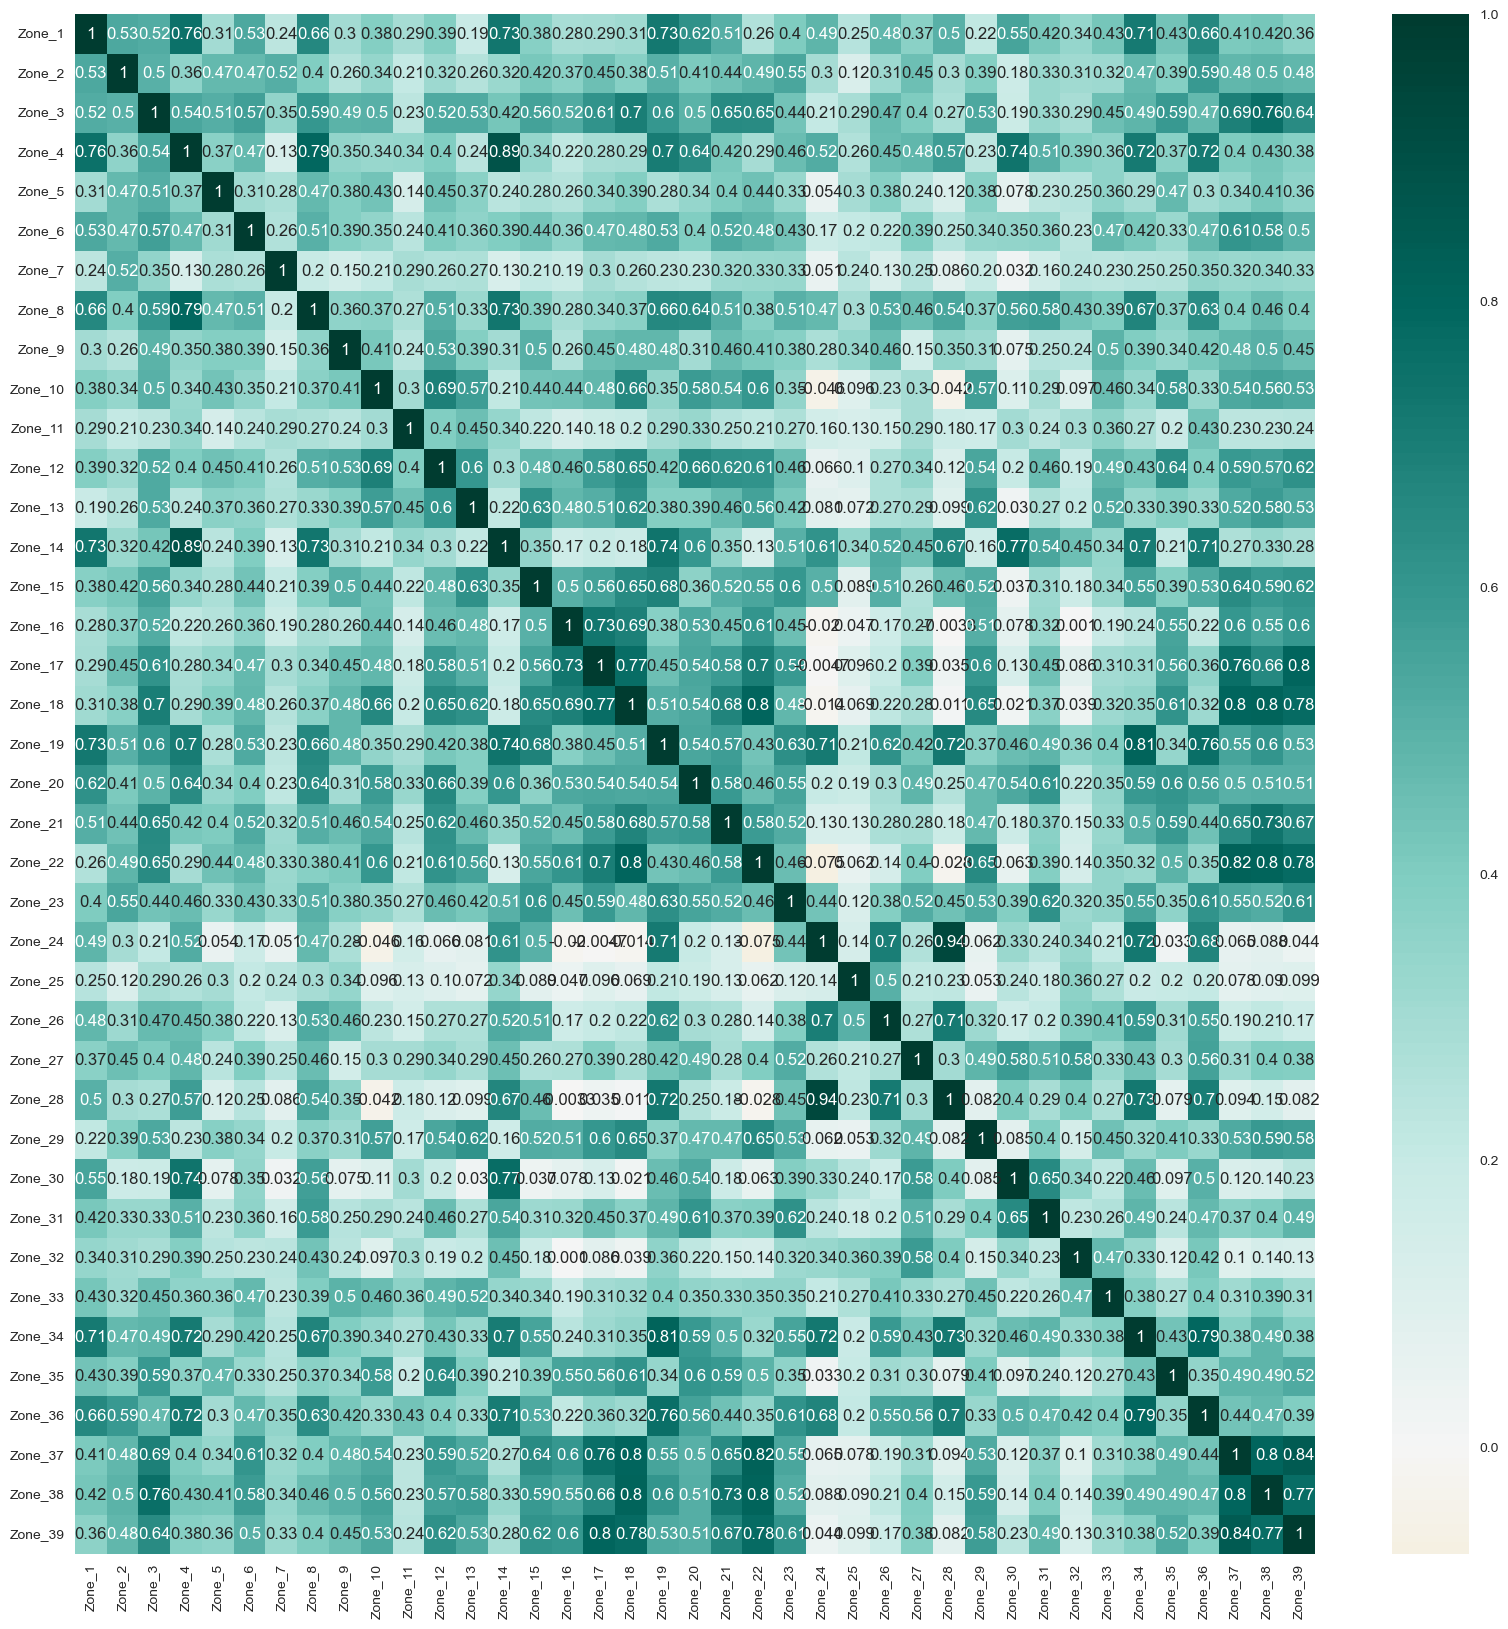

In [242]:
corrmat = scaled_sku_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat, annot=True, cmap='BrBG', center=0);

Looks like sales of a given item in a given zone often tend to be positively correlated with sales of that same item in a different zone.

## Dimensionality Reduction

Now, what do we mean by dimensionality reduction? Well, our dataset has plenty, plenty, plenty of features. Each of these adds a dimension to our dataset. Moreover, we saw through our correlation matrix that many of these features are correlated with each other and are thus redundant. 

We can reduce the number of features (dimensions) in our dataset and minimize the loss of information contained therein by means of Principal Component Analysis, a dimensionality reduction technique that linearly transforms our data to a new coordinate system such that the directions capturing the largest variation in our data can be more easily identified. 

In this case, we will collapse our data to three dimensions.

In [243]:
## Initiating PCA to reduce dimensions to 3
pca = PCA(n_components=3)
pca.fit(scaled_sku_df)
PCA_df = pd.DataFrame(pca.transform(scaled_sku_df), columns=(['col1', 'col2', 'col3']), index=pca_sku_df.index)
PCA_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,200.0,5.329071e-17,4.066733,-3.497948,-2.191135,-1.361407,0.445599,34.951016
col2,200.0,-4.440892e-17,2.283065,-12.755137,-0.704054,-0.220663,0.468585,16.081756
col3,200.0,3.552714e-17,1.441603,-11.323426,-0.261278,0.043880,0.291005,11.867752


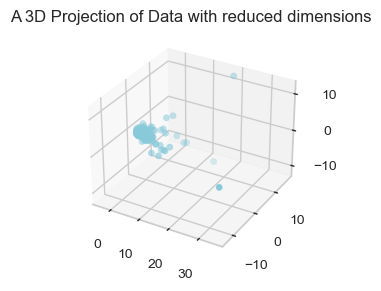

In [244]:
#A 3D Projection of Data with reduced dimensions
x = PCA_df['col1']
y = PCA_df['col2']
z = PCA_df['col3']

#To plot
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='c', marker='o')
ax.set_title("A 3D Projection of Data with reduced dimensions")
plt.show;

## Clustering

Now that our data has been collapsed into three dimensions, it's time to separate our datapoints into clusters by means of K-Means clustering. Here we make use of the elbow method to find the optimal amount of clusters to separate the data into. The elbow method is a simple heuristic, meant to minimize the distortion score within each cluster while taking account the diminishing returns associated with splitting the dataset into k+1 clusters.

Elbow method to determine the number of clusters we will form:


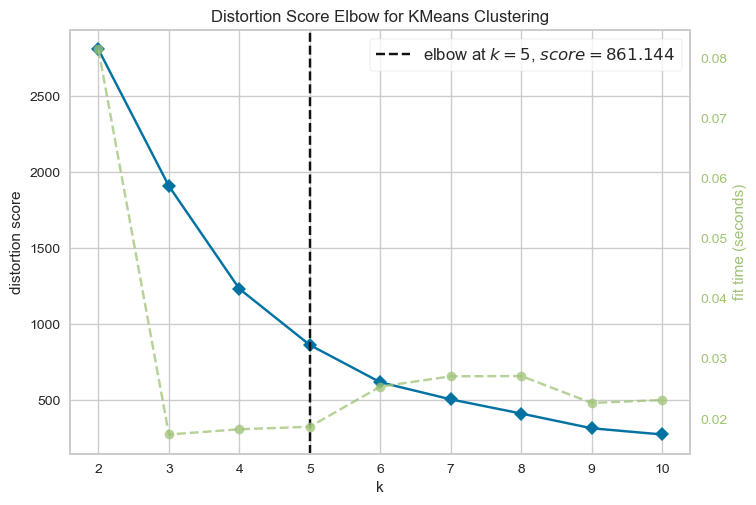

In [245]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow method to determine the number of clusters we will form:')
EM = KElbowVisualizer(KMeans(n_init=5), k=10)
EM.fit(PCA_df)
EM.show();

Looks like we're going to go for 5 clusters. Here we will use a clustering method called Agglomerative Clustering. Each data point starts off in its own cluster, and merges with the cluster closest to it within n-dimensional space. This is done until our desired number of clusters (5) is achieved.

In [246]:
# Initiating the Agglomerative Clustering Model
AC = AgglomerativeClustering(n_clusters=5)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_df)
PCA_df['Clusters'] = yhat_AC
# Adding the Clusters feature to the original dataframe
pca_sku_df['Clusters'] = yhat_AC

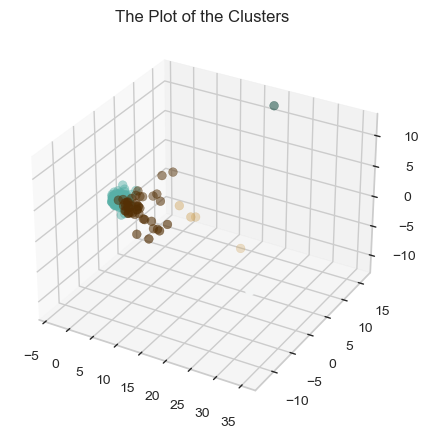

In [247]:
# 3D-Plotting the Clusters
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x, y, z, s=40, c=PCA_df['Clusters'], marker='o', cmap='BrBG')
ax.set_title('The Plot of the Clusters')
plt.show()

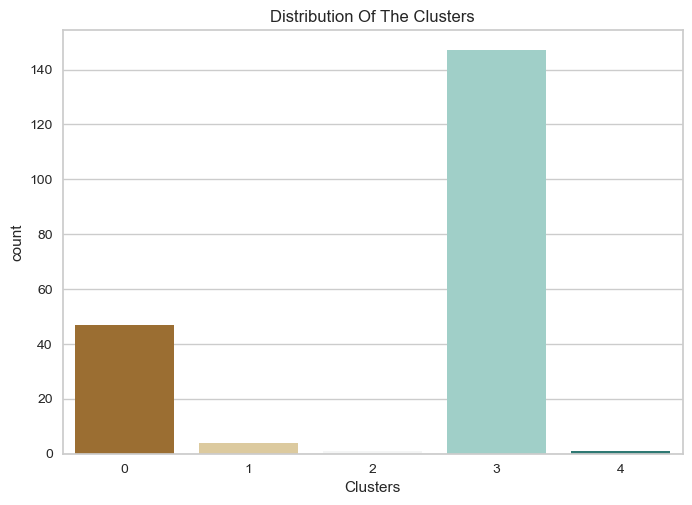

In [248]:
## Plotting countplot of clusters
pl = sns.countplot(x=pca_sku_df['Clusters'], palette= 'BrBG')
pl.set_title("Distribution Of The Clusters")
plt.show()

First thing that jumps out at us here is that clusters 1, 2, and 4 don't have that many SKUs in them. Let's take a look at which ones those are.

In [249]:
pca_sku_df[pca_sku_df['Clusters'].isin([1, 2, 4])][['Clusters']]

,Clusters
SKU,
SKU_015,1
SKU_022,1
SKU_047,1
SKU_097,2
SKU_107,1
SKU_162,4


Looks like the SKUs in these tiny clusters are our Top 6 selling SKUs overall. They exist in a class (or rather 3 classes) by themselves!

In [250]:
clusters_df = pca_sku_df.groupby('Clusters').sum().transpose().reset_index()
clusters_df.columns = ['Zone', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4']
clusters_df.head(10)

,Zone,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,Zone_1,2.566258e+08,8.038183e+07,1.975425e+07,2.729876e+08,2.303508e+07
1,Zone_2,1.326264e+08,1.268928e+07,9.063802e+06,1.459570e+08,9.510121e+06
2,Zone_3,1.748583e+08,1.602558e+07,3.409199e+07,1.685851e+08,9.029330e+06
3,Zone_4,1.761191e+08,9.406105e+07,2.134722e+07,1.896626e+08,1.772875e+07
4,Zone_5,1.446085e+08,4.633522e+06,7.323763e+06,1.101704e+08,1.867744e+06
5,Zone_6,2.356303e+08,4.079203e+07,2.076169e+07,2.287801e+08,8.259351e+06
6,Zone_7,9.596358e+07,4.421672e+06,9.822268e+06,1.478376e+08,3.164488e+06
7,Zone_8,2.149609e+08,5.085398e+07,1.784443e+07,1.996040e+08,1.471616e+07
8,Zone_9,1.339326e+08,7.105897e+06,1.256144e+07,1.594820e+08,6.859735e+06
9,Zone_10,2.018185e+08,1.444646e+07,1.820079e+07,2.159150e+08,1.786282e+06


In [251]:
clusters_melt = pd.melt(clusters_df, id_vars = ['Zone'], var_name = 'Cluster', value_name = 'Sales')

In [252]:
fig = px.bar(clusters_melt, x='Cluster', y='Sales', title='Total Sales by Cluster')
fig.show()

The vast majority of sales come from Cluster 0 and Cluster 3. Recall that Clusters 1, 2 and 4 only represent 6 SKUs in total. 

In [253]:
fig = px.bar(clusters_melt, x='Zone', y='Sales', color='Cluster', title='Distribution of Clusters Sales by Zone')
fig.show()

The distribution of Cluster 0 and Cluster 3 across all zones often resembles their distribution in the aggregate, with a handful of exceptions where Cluster 3 takes on a larger-than-average share of the total. The SKUs from Cluster 1 tend to make up a lower share of each zone's total, with a handful of exceptions in which their sales are more prominent, often in regions with sales larger than 0.5B. Cluster 4, representing the lone SKU_162, takes on a much larger-than-average share of a zone's sales in Zones 24 and 28 in particular.

In [254]:
top_cagr_zones = ['Zone_9', 'Zone_15', 'Zone_22', 'Zone_10', 'Zone_24']
clusters_melt_cagr = clusters_melt[clusters_melt['Zone'].isin(top_cagr_zones)]
fig = px.bar(clusters_melt_cagr, x='Zone', y='Sales', color='Cluster', title='Distribution of Clusters Sales by Zone - Top 5 Zones by CAGR')
fig.show()

Above we see can the distribution of clusters in the sales corresponding to the five zones with the highest CAGR. Zone 24, which we might be able to think of as our 'most successful' zone given its combination of high sales and high growth, differs from the other 4 high-growth zones in that Cluster 1 and Cluster 4 SKUs take up a larger percentage of its sales total. All other high-growth zones have a relatively even split between Cluster 0 and Cluster 3 products.

In [255]:
t_5 = [t.replace('Zone ', 'Zone_') for t in t_5]
clusters_melt_top5 = clusters_melt[clusters_melt['Zone'].isin(t_5)]
fig = px.bar(clusters_melt_top5, x='Zone', y='Sales', color='Cluster', title='Distribution of Cluster Sales by Zone - Top 5 Zones by Sales')
fig.show()

When we examine our Top 5 Zones by Sales, we see that Cluster 1 products tend to take up a higher percentage of the total compared to most other zones in our earlier visualizations, and that rather than having an even split between Cluster 0 and Cluster 3, Cluster 3 products tend to have higher sales than Cluster 0 products.

In [256]:
b_5 = [b.replace('Zone ', 'Zone_') for b in b_5]
clusters_melt_bot5 = clusters_melt[clusters_melt['Zone'].isin(b_5)]
fig = px.bar(clusters_melt_bot5, x='Zone', y='Sales', color='Cluster', title='Distribution of Cluster Sales by Zone - Bottom 5 Zones by Sales')
fig.show()

On the other hand, Cluster 1 SKUs are hardly present in the sales distribution for the Bottom 5 Zones by Sales.

### Principal Components Analysis and Clustering - Summary of Insights

Our attempt to segment SKUs into clusters has allowed us to observe the following:
1) Sales of a given SKU in one Zone are often positively correlated for sales of the same SKU in another Zone. This is true in the vast majority of cases.
2) There are a handful of SKUs that make up a significant, although not overwhelming portion of Sales: these are SKU_015, SKU_022, SKU_047, SKU_097, SKU_107, and SKU_162. These SKUs are noteworthy in that the bulk of their sales is concentrated in a handful of Zones that have high sales to begin with.
3) SKUs in Cluster 3 have the potential to take up the largest share of sales in the Zones in which they are sold - this potential is often realized in high-sales Zones.
4) Similarly, SKU_162, the one SKU in Cluster 4, has the potential to take up a marginally larger share of the total sales of a given Zone - however, this potential has only been realized in the top two Zones by sales.

# Addresssing Company X's Drop in Sales

In the EDA phase of this project, we observed that Company X's sales have suddenly collapsed in December 2022. This requires us to think about what we might to do to drive sales and correct this problem. 

Our attempt to leverage PCA to group SKUs into clusters gave us an understanding of which groups of SKUs sell where, and what the distribution of SKUs in high-sales and high-growth zones might tell us about what opportunities for growth might exist.

We would recommend the following:
1) We should examine consumer behavior corresponding to SKUs in Cluster 3 and Cluster 1: Of the Clusters observed, SKUs corresponding to Cluster 3 are our largest growth opportunity, with the potential to represent an even larger share of total sales in each Zone, a potential which is evinced by their large share of total sales in our most successful markets. If we can, for example, identify opportunities for promotions and bundling within that cluster (or even across clusters) we should be able to drive growth. The same logic applies to SKUs in Cluster 1, albeit the impact of growing its share of sales would be smaller compared to that of Cluster 3.

2) Examine the characteristics of SKU_162 (Cluster 4) to understand how to drive sales outside of major markets: In lieu of more information, it's hard to understand why SKU_162 only sells in large quantities in the Zones that already have the largest sales. Perhaps it's a product that is only relevant in urban contexts. If, however, its low sales are a result of Company X's struggles to gain market share in its category, it might benefit from a discount campaign.

3) Adopt a one-size-fits-all growth strategy for SKUs in Cluster 0: What's remarkable about SKUs in Cluster 0 is that their sales are similar across the majority of Zones in question. Whatever route we take to increase their sales, be it a discount, a promotion, different forms of bundling, etc, there's no suggestion that given strategy would play out differently in different Zones.

Now, what makes specific recommendations on precisely what to do challenging is that we don't have information on our SKUs' margins, their categories, the characteristics that give them competitive advantage over Company X competitors' products, etc. For example, simply 'offering a discount' on products in Cluster 0 could prove to be disadvantageous if their margins aren't wide enough.

However, let's suppose that we *do* have that information on hand. Our recommendations might apply immediately, given the sudden drop in sales. However, we would prefer to have a periodic plan of when to offer discounts, promotions, bundles etc. This requires us to understand the seasonal nature of our sales overall. In the next section, we try our hand at time-series analysis and attempt to build a model that will allow us to predict drops in sales such that we're ready to act when situations like that observed in Defcember 2022 come along.

# Time Series Forecasting

Let's take a look at our overall sales again.

In [257]:
m_df = monthly_df.set_index('Month')

In [258]:
fig = px.line(monthly_df, x='Month', y='Sales', title='Total Sales by Month (2017-2022)')
fig.show()

It looks like our sales oscillate a bit, but they tend to go up over time. How might we describe this time-series in order to model it? 

We can think of every time series as having 4 parts:
1) Level: the baseline value for the series if it was a straight line
2) Trend: the optional and often linear increasing or decreasing behavior of the time series over time
3) Seasonality: the optional repeating patterns or cycles of behavior over time
4) Noise: the optional variability in the observations that cannot be explained by the model

Taking these pieces into account will allow us to build what's called a SARIMA model, or Seasonal AutoRegressive Integrated Moving Average model.

Although this presentation won't lend itself to the techinical nitty-gritty of how this model works, more information can be found here: [https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6]

#### Determining Seasonality

It seems to me that we have additive seasonality, in which we see more-or-less constant variance as our trendline of sales edges upward.

#### Determining Seasonal Period

Our data is monthly so we take our period = S = m = 12

## Decomposing the Data

Here we decompose our series in order to observe the 4 parts of our series mentioned above and determine if seasonality is truly present in our data. In particular we want to sanity-check whether or not we're seeing additive seasonality in our time-series, which should show up in the form of evenly-distributed residuals.

In [259]:
decomposed_result = seasonal_decompose(m_df, model = 'additive', period = 12)

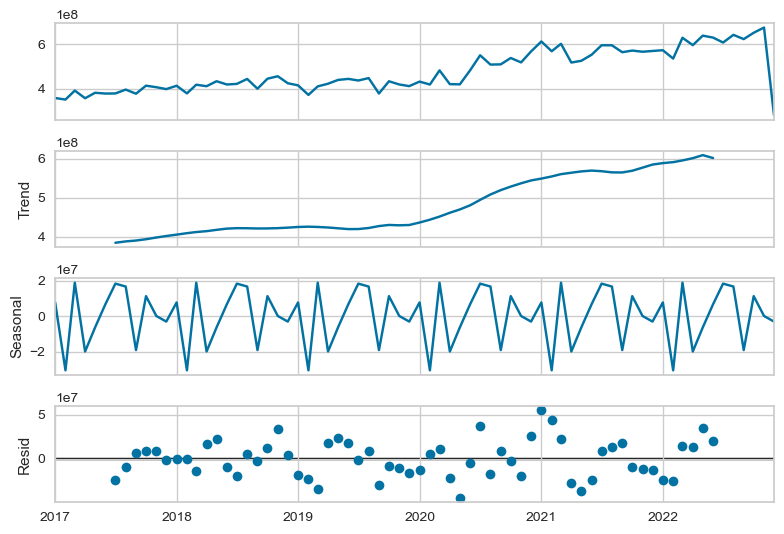

In [260]:
decomposed_result.plot();

It looks like our assumption of additive seasonality checks out!

### Determining Stationarity

Stationarity refers to attributes of a given dataset not changing over time, such as data having a constant mean, variance, and covariance between periods of equal distance. We will use an Augumented Dickey-Fuller hypothesis test to ensure stationarity and determine d and D in our SARIMA model.

In [261]:
def interpret_dftest(target_column):
    '''Returns the Test Statistic and p-value for Augmented Dickey-Fuller test on given target column'''
    dftest = adfuller(target_column)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [262]:
# original data (d=0)
interpret_dftest(m_df)

Test Statistic   -1.988746
p-value           0.291529
dtype: float64

In [263]:
# once-differenced data (d=1)
interpret_dftest(m_df.diff().dropna())

Test Statistic   -4.672903
p-value           0.000095
dtype: float64

Thus we set d=1 and D=1.

## Determining the AR and MA components of our model.

Let's simply use auto_arima for these.

In [264]:
# ONLY using the target
y = m_df 

# shuffle = False given we're working with time-series data
y_train, y_test = train_test_split(y, test_size = 0.2, shuffle = False)

In [265]:
stepwise_sarima = auto_arima(
    y_train, # data
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
    d = 1, # we know how much to difference, so don't need to waste time searching for this,
    D = 1, # we know how much to difference, so don't need to waste time searching for this,
    seasonal = True, 
    m = 12, # we must specify which seasonal period to use
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1647.467, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1649.736, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1649.742, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1648.328, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1655.922, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1663.140, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1647.748, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1647.762, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=1647.857, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.394 seconds


In [266]:
## What was the best order?
stepwise_sarima.order

(0, 1, 0)

In [267]:
# What was the best seasonal order?
stepwise_sarima.seasonal_order

(0, 1, 0, 12)

We've determined the best order and seasonal order for our model, let's take a look at the summary of the model our search arrived at:

In [268]:
stepwise_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   57
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -822.733
Date:                            Wed, 29 May 2024   AIC                           1647.467
Time:                                    11:59:56   BIC                           1649.251
Sample:                                01-01-2017   HQIC                          1648.128
                                     - 09-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.595e+14   1.22e+14      6.202      0.000    5.19e+14    9.99e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                 1.09
Prob(Q):                              0.41   Prob(JB):                         0.58
Heteroskedasticity (H):               5.83   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's take a few quick diagnostics of our model and see if anything is out of order.

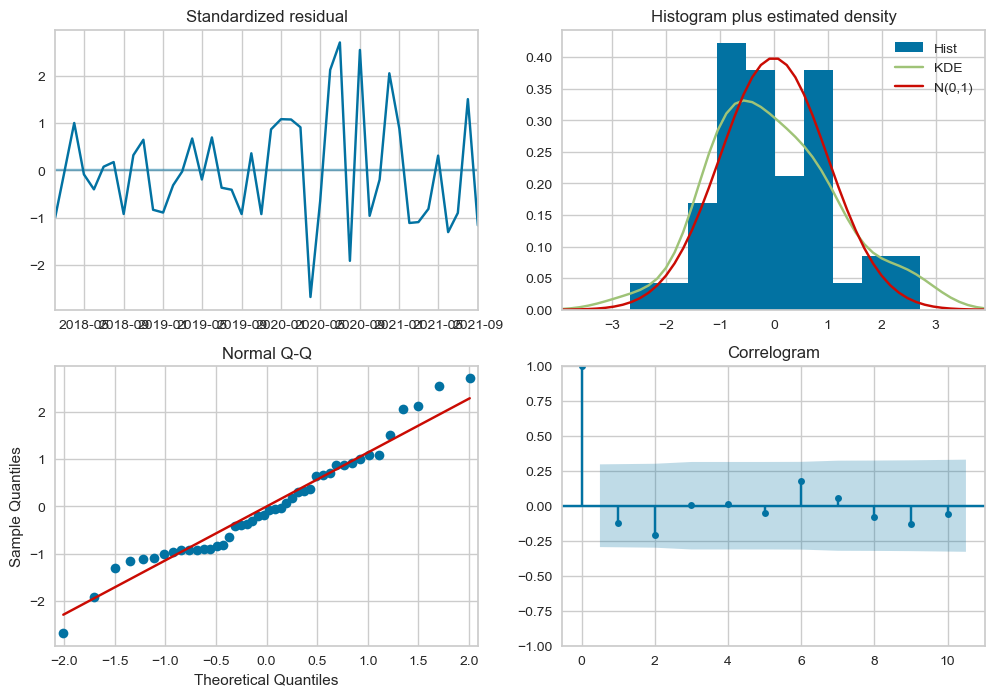

In [269]:
stepwise_sarima.plot_diagnostics(figsize = (12, 8));

In particular, our standardized residuals seem to have constant variance, and our QQ plot demonstrates a distribution of datapoints settled snugly along the diagonal. No red flags here.

Now let's actually build the model that we originally specified such that we may make predictions off of it.

In [270]:
## Builiding Model

order = (0, 1, 0)
seasonal_order = (0, 1, 0, 12)

# instantiate
tour_sarima = SARIMAX(
    y_train, 
    order = order, 
    seasonal_order = seasonal_order, 
    freq = 'MS', # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enforce stationarity (use d and D)
)

# fit
fitted_tour_sarima = tour_sarima.fit(maxiter = 200, method = "powell", disp = 0) 

/Users/ricardoalatorre/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [271]:
fitted_tour_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   57
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -803.366
Date:                            Wed, 29 May 2024   AIC                           1608.732
Time:                                    11:59:58   BIC                           1610.494
Sample:                                01-01-2017   HQIC                          1609.382
                                     - 09-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.893e+14    2.1e+14      4.700      0.000    5.77e+14     1.4e+15
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                 0.86
Prob(Q):                              0.40   Prob(JB):                         0.65
Heteroskedasticity (H):               5.50   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Our model will attempt to forecast the sales corresponding to 2022. Let's see how it does.

In [272]:
num_steps = len(y_test)
test_forecast = fitted_tour_sarima.forecast(steps=num_steps)
test_forecast

2021-10-01    5.927004e+08
2021-11-01    5.729435e+08
2021-12-01    6.221432e+08
2022-01-01    6.668526e+08
2022-02-01    6.230920e+08
2022-03-01    6.564582e+08
2022-04-01    5.723111e+08
2022-05-01    5.801289e+08
2022-06-01    6.074149e+08
2022-07-01    6.499334e+08
2022-08-01    6.497704e+08
2022-09-01    6.187405e+08
2022-10-01    6.472764e+08
2022-11-01    6.275195e+08
2022-12-01    6.767191e+08
Freq: MS, Name: predicted_mean, dtype: float64

In [273]:
t_df = m_df[m_df.index > '2021-09-01'].join(pd.DataFrame({'Forecasted_Sales': test_forecast})).reset_index()
t_df

,Month,Sales,Forecasted_Sales
0,2021-10-01,5.714666e+08,5.927004e+08
1,2021-11-01,5.662581e+08,5.729435e+08
2,2021-12-01,5.696625e+08,6.221432e+08
3,2022-01-01,5.730612e+08,6.668526e+08
4,2022-02-01,5.355652e+08,6.230920e+08
5,2022-03-01,6.289626e+08,6.564582e+08
6,2022-04-01,5.958846e+08,5.723111e+08
7,2022-05-01,6.384344e+08,5.801289e+08
8,2022-06-01,6.296853e+08,6.074149e+08
9,2022-07-01,6.075890e+08,6.499334e+08


With the exception of December 2022, it seems like our model does a reasonable job of guessing how much sales Company X will enjoy several months in advance. Let's visualize Sales and Forecasted Sales to get a clearer impression.

In [274]:
a_df = m_df[m_df.index > '2021-09-01'].reset_index()
a_df['Type'] = 'Actual'
b_df = pd.DataFrame({'Sales': test_forecast}).reset_index().rename(columns={'index': 'Month'})
b_df['Type'] = 'Forecast'
t_df = a_df.append(b_df)
fig = px.line(t_df, x='Month', y='Sales', color='Type', title='Forecasted Sales vs Sales [Oct 2021-Dec 2022]')
fig.show()

/var/folders/h4/65kflncx7_7dv43420nzkyr80000gn/T/ipykernel_82541/820693526.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



It seems that our straightforward SARIMA model, working with only about 60 or so datapoints, was capable of forecasting roughly a year's worth of sales in advance reasonably well, with one major exception: the sales corresponding to December 2022. 

### Time-Series Forecasting Insights and Additional Recommendations

Our brief exercise in time-series forecasting suggests a few things:
1) Even a simple time-series forecasting model like a SARIMA model can give Company X a reasonable estimate of how much sales they can expect to make in a given month. Company X should maintain and refine such a model in order to time the growth strategies we alluded to in an earlier section to those periods of the year in which they are most needed.
2) The stark degree to which our forecast singularly failed to anticipate the drop in sales in December 2022 suggests that this drop in sales was not reflective of sales' seasonality but was instead likely driven by an exogenous shock of some kind. Company X should examine what its competitors are doing - perhaps Company X is being severly undercut on price as part of an end-of-year discount sale of some kind. If the shock is a one-time event, Company X might not have to change its overall strategy, but if a competitor has somehow gained a severe competitive advantage over it somehow the company must adjust as soon as possible.

## Recommendations for Further Analysis

In this analysis, our use of unsupervised machine learning methods allowed us to spot a handful of patterns concerning the distribution of SKU sales in different regions. Our use of time-series modeling, on the other hand, allowed us to anticipate how much in sales Company X would likely expect to be able to make in a given month, several months in advance, as well as suggesting that the collapse in sales in December 2022 is likely the result of an exogenous shock.

However, it seems to us that the main benefit of this analysis has been to identify what needs to be looked into in order to improve sales, rather than coming upon any particular strategy to do so. Exactly *what* particular strategy to boost sales will be most effectve requires we understand the SKUs in play more in-depth. For example, if it turns out that the SKUs in Cluster 3 have low margins, a strategy to offer discounts on these items might boost sales but could turn out to be highly unprofitable. A strategy to bundle SKU_162 with other SKUs might be a waste of time if SKU_162 turns out to be an item that is only relevant in certain zones/contexts.

If we were working with or at Company X, we would want to get our hands on information relating to SKU product categories, profit margins, as well as any historical information of demand elasticities by zone in order to understand the potential impact of any one strategy on a given category of SKUs. We should also try to understand the nature of the (likely) exogenous shock to sales the company suffered in December 2022. If a competitor undercut the company on price in an end-of-year sale, the company should think of what it can do to avoid the same situation next year. If the shock came as a result of regulatory changes or the entry of a new player into the market with significant competitive advantages, Company X might have to review its overall strategy.